In [36]:
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [1]:
#set up code
import sys
sys.path.append('../ProLib')
from ProteomicsUtility import utilities as PTUT
import ProtRank
import warnings
warnings.filterwarnings("ignore")
#define helphttp://localhost:8888/notebooks/calvin/new_data/analysis_427_2018.ipynb#ing function
import os
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text
from matplotlib.lines import Line2D
from Bio import SeqIO
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
plt.style.use('ggplot')

In [2]:
OUT_FOLDER = '927/'

In [3]:
df = pd.read_csv('927/proteinGroups_ibaq.txt',sep='\t')
df = PTUT.clean_df(df, score=-1, unique_pep_threshold=-1)

starting from: (7075, 1507)
removed  222 Protein Groups by: Only identified by site
tot  222  entries removed
---------------
removed  67 Protein Groups by: Reverse
tot  289  entries removed
---------------
removed  143 Protein Groups by: Potential contaminant
tot  432  entries removed
---------------
Score
nothing removed
---------------
Peptide counts (razor+unique)
nothing removed
---------------


In [4]:
bsf_cols = [n for n in  list(df.columns) if 'iBAQ H BSF' in n]
bsf = df[bsf_cols]
bsf.columns = [n.split(' ')[-1] for n in bsf.columns]
bsf_cols = bsf.columns
pcf_cols = [n for n in  list(df.columns) if 'iBAQ H PCF' in n]
pcf = df[pcf_cols]
pcf.columns = [n.split(' ')[-1] for n in pcf.columns]
pcf_cols = pcf.columns
bsf = bsf.replace(0,np.nan)
pcf = pcf.replace(0,np.nan)
bsf.head()
merge = pd.concat([bsf,pcf],axis=1)
merge.head()

,BSF_1,BSF_10,BSF_11,BSF_12,BSF_13,BSF_14,BSF_15,BSF_16,BSF_17,BSF_18,...,PCF_25,PCF_26,PCF_27,PCF_3,PCF_4,PCF_5,PCF_6,PCF_7,PCF_8,PCF_9
163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18573000.0,20727000.0,11592000.0,15733000.0,13488000.0,8017600.0,23501000.0,3685100.0,7971900.0,33116000.0
164,11530000.0,16113000.0,15700000.0,12597000.0,11177000.0,16781000.0,14136000.0,17894000.0,14760000.0,14883000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN,NaN,7710.2,17054.0,7753.4,21114.0,3657.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,4941.2,81635.0,57929.0,NaN,20322.0,29168.0,14464.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,75872.0,113910.0,118140.0,82414.0,75623.0,97324.0,101580.0,85075.0,75567.0,82928.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


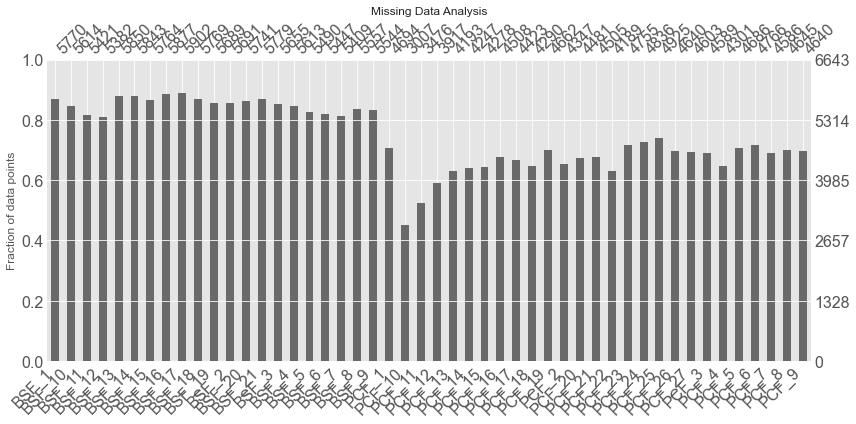

In [25]:
import missingno as msno
#visualization of missing data
ax=msno.bar(merge,figsize=(12, 6))
plt.title('Missing Data Analysis', size=12)
ax.set_ylabel('Fraction of data points',size=12)
plt.savefig(os.path.join(OUT_FOLDER,'1_missing_value.png'))
plt.tight_layout()
plt.show()

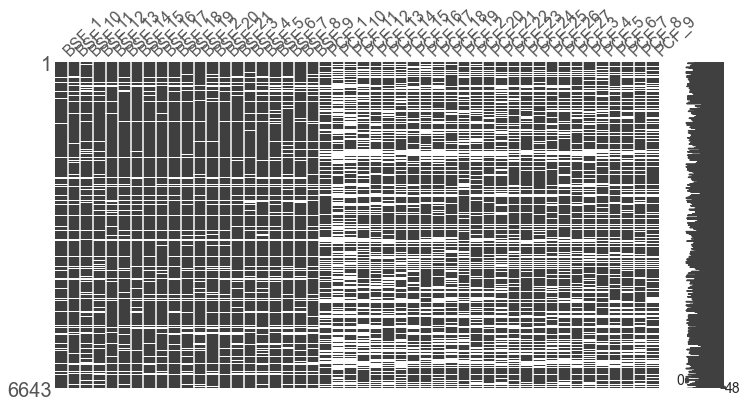

In [26]:
#print(data.shape)
msno.matrix(merge, figsize=(12, 6))
#plt.title('Missing Data')
plt.savefig(os.path.join(OUT_FOLDER,'missing_value_matrix.png'))
plt.show()

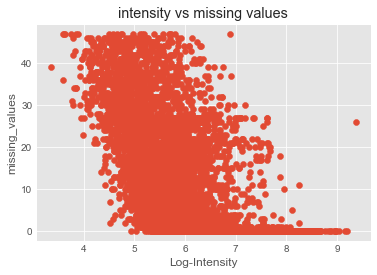

In [15]:
mean_intesity = np.log10(merge.mean(axis=1))
na_sum = merge.isna().sum(axis=1).astype(int)
plt.scatter(mean_intesity,na_sum)
plt.xlabel('Log-Intensity')
plt.ylabel('missing_values')
plt.title('intensity vs missing values')
plt.show()

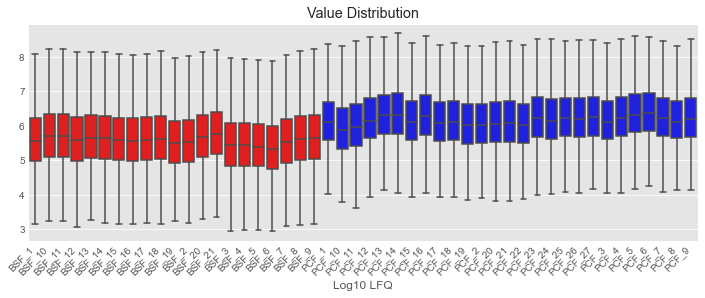

In [16]:
palette=['r']*len(bsf_cols)+['b']*len(pcf_cols)
palette_g = ['r','b']
color_dictionary = {'r':'BSF','b':'PCF'}


fig,ax=plt.subplots(figsize=(12,4))
sns.boxplot(data=np.log10(merge),showfliers=False,palette=palette,ax=ax)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.xticks(rotation=45,ha='right')
plt.savefig(os.path.join(OUT_FOLDER,'4_value_distribution_box.png'))
plt.show()

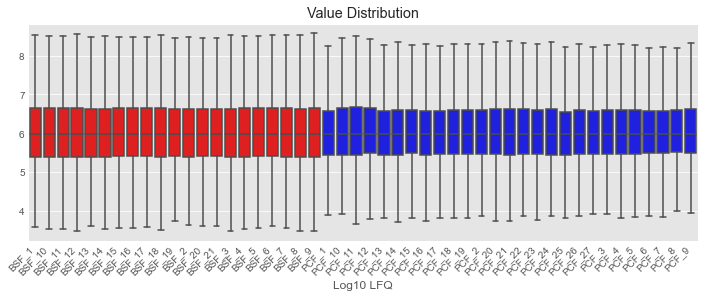

In [38]:
#https://codereview.stackexchange.com/questions/25417/is-there-a-better-way-to-make-a-function-silent-on-need
class NoStdStreams(object):
    def __init__(self, stdout = None, stderr = None):
        self.devnull = open(os.devnull,'w')
        self._stdout = stdout or self.devnull or sys.stdout
        self._stderr = stderr or self.devnull or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr
        self.devnull.close()

with NoStdStreams():
    merge_normed = PTUT.norm_loading(merge)

fig,ax=plt.subplots(figsize=(12,4))
sns.boxplot(data=np.log10(merge_normed),showfliers=False,palette=palette,ax=ax)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.xticks(rotation=45,ha='right')
plt.savefig(os.path.join(OUT_FOLDER,'4_value_distribution_box.png'))
plt.show()

In [39]:
#merge_normed['bsf_median']=merge_normed[bsf_cols].median(axis=1,skipna=True)
#merge_normed['pcf_median']=merge_normed[pcf_cols].median(axis=1,skipna=True)
#merge_normed.head()

In [40]:
log_merge_normed = np.log10(merge_normed)
log_merge_normed.head()

,BSF_1,BSF_10,BSF_11,BSF_12,BSF_13,BSF_14,BSF_15,BSF_16,BSF_17,BSF_18,...,PCF_25,PCF_26,PCF_27,PCF_3,PCF_4,PCF_5,PCF_6,PCF_7,PCF_8,PCF_9
163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.034222,7.129269,6.818942,7.076467,6.900299,6.577278,6.999386,6.34199,6.782959,7.330628
164,7.501275,7.505302,7.486695,7.520282,7.393861,7.578973,7.561735,7.690670,7.576066,7.541315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN,NaN,4.241221,4.643235,4.327455,4.731550,3.931773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,4.133278,5.210002,5.053691,NaN,4.653502,4.819062,4.571697,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,5.319528,5.354688,5.363192,5.336016,5.224190,5.342375,5.418217,5.367765,5.285312,5.287325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
%%R -i log_merge_normed
options(warn=-1)
library("missForest")
library("doParallel")
registerDoParallel(cores=6)
imputed_X <- missForest(log_merge_normed, ntree = 50, parallelize = "forests" )$ximp


  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!
  missForest iteration 6 in progress...done!
  missForest iteration 7 in progress...done!
  missForest iteration 8 in progress...done!
  missForest iteration 9 in progress...done!
  missForest iteration 10 in progress...done!


In [42]:
%R -o imputed_X  
imputed_X.index = merge.index
imputed_X.head()

,BSF_1,BSF_10,BSF_11,BSF_12,BSF_13,BSF_14,BSF_15,BSF_16,BSF_17,BSF_18,...,PCF_25,PCF_26,PCF_27,PCF_3,PCF_4,PCF_5,PCF_6,PCF_7,PCF_8,PCF_9
163,5.551680,5.593679,5.443258,5.451128,5.570693,5.584836,5.544396,5.638799,5.599815,5.627937,...,7.034222,7.129269,6.818942,7.076467,6.900299,6.577278,6.999386,6.341990,6.782959,7.330628
164,7.501275,7.505302,7.486695,7.520282,7.393861,7.578973,7.561735,7.690670,7.576066,7.541315,...,5.164036,5.273730,5.047028,5.221884,5.221522,5.234504,5.160612,5.278185,5.114584,5.212008
165,4.252521,4.344118,3.937760,4.379077,4.460870,4.241221,4.643235,4.327455,4.731550,3.931773,...,5.454153,5.392496,5.219119,5.094332,5.108368,5.101938,5.022434,5.098609,5.071156,5.044093
166,4.133278,5.210002,5.053691,5.055875,4.653502,4.819062,4.571697,4.836373,4.735120,4.786403,...,5.284022,5.310129,5.166282,5.120365,5.042949,5.030828,5.080929,5.222217,5.121692,5.056294
167,5.319528,5.354688,5.363192,5.336016,5.224190,5.342375,5.418217,5.367765,5.285312,5.287325,...,5.078609,5.032822,5.113134,5.080398,4.996079,5.090834,5.110332,5.224666,5.083431,5.044709


In [46]:
#imputed_X.loc[[172]].plot(kind='bar')

In [47]:
#fig,ax=plt.subplots(figsize=(8,8))
#imputed_X.plot(kind='scatter',x='log_pcf_median',y='log_bsf_median',ax=ax)
#imputed_X.loc[[172]].plot(kind='scatter',x='log_pcf_median',y='log_bsf_median',ax=ax,c='r')

In [48]:
imputed_X['bsf_median']=imputed_X[bsf_cols].median(axis=1)
imputed_X['pcf_median']=imputed_X[pcf_cols].median(axis=1)

In [50]:
imputed_X['rank_bsf_median']=imputed_X['bsf_median'].rank(method='min')
imputed_X['rank_pcf_median']=imputed_X['pcf_median'].rank(method='min')

<AxesSubplot:xlabel='bsf_median', ylabel='pcf_median'>

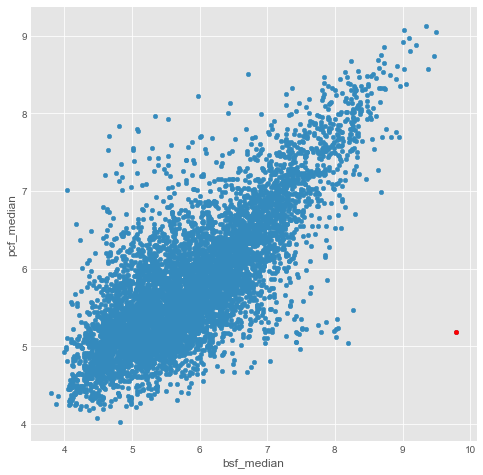

In [52]:
fig,ax=plt.subplots(figsize=(8,8))
imputed_X.plot(kind='scatter',x='bsf_median',y='pcf_median',ax=ax)
imputed_X.loc[[172]].plot(kind='scatter',x='bsf_median',y='pcf_median',ax=ax,c='r')

<AxesSubplot:xlabel='rank_bsf_median', ylabel='rank_pcf_median'>

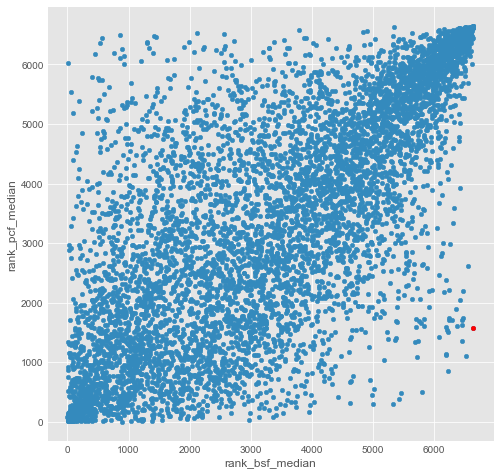

In [53]:
fig,ax=plt.subplots(figsize=(8,8))
imputed_X.plot(kind='scatter',x='rank_bsf_median',y='rank_pcf_median',ax=ax)
imputed_X.loc[[172]].plot(kind='scatter',x='rank_bsf_median',y='rank_pcf_median',ax=ax,c='r')

In [59]:
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int
163,gene-Tb427.BES40.1,gene-Tb427.BES40.1,12,12,12,gene-Tb427.BES40.1 lcl|FM162566.1_prot_CAQ5727...,1,12,12,12,...,163,3020;29323;42773;43014;51958;68122;76679;82146...,True;True;True;True;True;True;True;True;True;T...,3324;32339;47073;47352;57107;75564;85952;91692...,102897;102898;102899;102900;102901;102902;1029...,165259;165260;165261;165262;165263;165264;1652...,165281;1363160;1984376;1991954;2438470;3159155...,188;189,1;26,12
164,gene-Tb427.BES40.10;Tb11.57.0050.1-p1;Tb11.114...,gene-Tb427.BES40.10,21;3;3;2;2;2;2;2;2;2;2;2;2;1;1;1;1,9;0;1;0;0;0;1;0;0;0;0;0;0;1;0;1;0,4;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,gene-Tb427.BES40.10 lcl|FM162566.1_prot_CAQ572...,17,21,9,4,...,164,16215;20764;23323;29656;37679;38919;38920;4239...,True;False;True;False;True;False;False;False;F...,17860;22874;25655;25656;32689;41526;41527;4288...,488182;488183;488184;488185;488186;488187;4881...,791739;791740;791741;791742;791743;791744;7917...,791748;992098;1103432;1381081;1755688;1811935;...,190;191;192;193;194;195,78;130;155;157;171;272,9
165,gene-Tb427.BES40.13,gene-Tb427.BES40.13,26,5,5,gene-Tb427.BES40.13 lcl|FM162566.1_prot_CAQ572...,1,26,5,5,...,165,116;1821;2098;16505;17506;25684;30750;31406;40...,False;False;False;False;False;False;False;Fals...,133;2015;2319;18239;19320;28356;33862;34593;44...,5432;5433;5434;5435;5436;5437;5438;5439;66180;...,9446;9447;9448;9449;9450;9451;9452;9453;108937...,9448;108964;124043;806094;847770;1199020;14344...,196;197,953;1101,5
166,gene-Tb427.BES40.14,gene-Tb427.BES40.14,30,3,3,gene-Tb427.BES40.14 lcl|FM162566.1_prot_CAQ572...,1,30,3,3,...,166,11404;15484;15844;22545;23527;23535;23795;2552...,False;False;False;False;False;False;False;Fals...,12642;17031;17420;24810;24811;25882;25890;2616...,363031;363032;363033;363034;363035;363036;4672...,594168;594169;594170;594171;594172;594173;7587...,594172;758739;773702;1067305;1113497;1113620;1...,198;199;200,9;68;85,3
167,gene-Tb427.BES40.15,gene-Tb427.BES40.15,31,1,0,gene-Tb427.BES40.15 lcl|FM162566.1_prot_CAQ572...,1,31,1,0,...,167,11404;11833;15484;15844;22545;23527;23535;2379...,False;False;False;False;False;False;False;Fals...,12642;13090;17031;17420;24810;24811;25882;2589...,363031;363032;363033;363034;363035;363036;3692...,594168;594169;594170;594171;594172;594173;6042...,594172;604222;758739;773702;1067305;1113497;11...,198;199;200,9;68;85,1


In [63]:
temp = PTUT.mod_df(imputed_X.join(df,how='left'))
temp['Gene_acc']=np.arange(temp.shape[0])
temp.rename({'desc':'Desc'},axis=1,inplace=True)
temp.head()

,BSF_1,BSF_10,BSF_11,BSF_12,BSF_13,BSF_14,BSF_15,BSF_16,BSF_17,BSF_18,...,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int,Gene_id,Desc,Gene_acc
163,5.551680,5.593679,5.443258,5.451128,5.570693,5.584836,5.544396,5.638799,5.599815,5.627937,...,3324;32339;47073;47352;57107;75564;85952;91692...,102897;102898;102899;102900;102901;102902;1029...,165259;165260;165261;165262;165263;165264;1652...,165281;1363160;1984376;1991954;2438470;3159155...,188;189,1;26,12,gene-Tb427.BES40.1,BES40.1,0
164,7.501275,7.505302,7.486695,7.520282,7.393861,7.578973,7.561735,7.690670,7.576066,7.541315,...,17860;22874;25655;25656;32689;41526;41527;4288...,488182;488183;488184;488185;488186;488187;4881...,791739;791740;791741;791742;791743;791744;7917...,791748;992098;1103432;1381081;1755688;1811935;...,190;191;192;193;194;195,78;130;155;157;171;272,9,gene-Tb427.BES40.10,BES40.10,1
165,4.252521,4.344118,3.937760,4.379077,4.460870,4.241221,4.643235,4.327455,4.731550,3.931773,...,133;2015;2319;18239;19320;28356;33862;34593;44...,5432;5433;5434;5435;5436;5437;5438;5439;66180;...,9446;9447;9448;9449;9450;9451;9452;9453;108937...,9448;108964;124043;806094;847770;1199020;14344...,196;197,953;1101,5,gene-Tb427.BES40.13,BES40.13,2
166,4.133278,5.210002,5.053691,5.055875,4.653502,4.819062,4.571697,4.836373,4.735120,4.786403,...,12642;17031;17420;24810;24811;25882;25890;2616...,363031;363032;363033;363034;363035;363036;4672...,594168;594169;594170;594171;594172;594173;7587...,594172;758739;773702;1067305;1113497;1113620;1...,198;199;200,9;68;85,3,gene-Tb427.BES40.14,BES40.14,3
167,5.319528,5.354688,5.363192,5.336016,5.224190,5.342375,5.418217,5.367765,5.285312,5.287325,...,12642;13090;17031;17420;24810;24811;25882;2589...,363031;363032;363033;363034;363035;363036;3692...,594168;594169;594170;594171;594172;594173;6042...,594172;604222;758739;773702;1067305;1113497;11...,198;199;200,9;68;85,1,gene-Tb427.BES40.15,BES40.15,4


In [65]:
!mkdir -p 'web_data/E927'

In [80]:
temp[['Gene_acc','Gene_id','bsf_median',
      'pcf_median','rank_bsf_median','rank_pcf_median','Desc',
      'Protein IDs']].to_csv('web_data/E927/indata.csv',index=False)

In [78]:
pcf_cols

Index(['PCF_1', 'PCF_10', 'PCF_11', 'PCF_12', 'PCF_13', 'PCF_14', 'PCF_15', 'PCF_16', 'PCF_17', 'PCF_18', 'PCF_19', 'PCF_2', 'PCF_20', 'PCF_21', 'PCF_22',
       'PCF_23', 'PCF_24', 'PCF_25', 'PCF_26', 'PCF_27', 'PCF_3', 'PCF_4', 'PCF_5', 'PCF_6', 'PCF_7', 'PCF_8', 'PCF_9'],
      dtype='object')

In [84]:
temp2 = merge_normed.fillna(0)
temp2 = PTUT.mod_df(temp2.join(df,how='left'))

temp2['Gene_acc']=np.arange(temp2.shape[0])
temp2.rename({'desc':'Desc'},axis=1,inplace=True)
#temp2[list(bsf_cols)+list(pcf_cols)]=np.log10(temp2[list(bsf_cols)+list(pcf_cols)])

temp2[['Gene_acc','Gene_id']+list(bsf_cols)+list(pcf_cols)+['Desc','Protein IDs']].to_csv('web_data/E927/indata2.csv',index=False)



In [ ]:

temp=all_df_select[['Gene_acc','PG.ProteinAccessions',
                    'P87-M87_logFC','P87-M87_AveExpr','P87-M87_adj.P.Val','Desc','Protein IDs']]

temp.columns = ['Gene_acc','Gene_id','logFC','log_AveExpr','FDR','Desc']
temp.to_csv('web_data/E927/indata.csv',index=False)


all_df_select[['Gene_acc','Gene_id','87P1','87P2','87P3',
      '87M1','87M2','87M3','Desc']].to_csv('web_data/E927/indata2.csv',index=False)



In [ ]:
bsf['bsf_mean']=bsf[bsf_cols].mean(axis=1,skipna=True)
bsf['bsf_median']=bsf[bsf_cols].median(axis=1,skipna=True)
bsf['bsf_std']=bsf[bsf_cols].std(axis=1,skipna=True)
bsf['bsf_cv']=bsf['bsf_std']/bsf['bsf_mean']
bsf['bsf_values']=bsf[bsf_cols].shape[1]-bsf[bsf_cols].isna().sum(axis=1)
bsf.head()

In [ ]:
pcf['pcf_mean']=pcf[pcf_cols].mean(axis=1,skipna=True)
pcf['pcf_median']=pcf[pcf_cols].median(axis=1,skipna=True)
pcf['pcf_std']=pcf[pcf_cols].std(axis=1,skipna=True)
pcf['pcf_cv']=pcf['pcf_std']/pcf['pcf_mean']
pcf['pcf_values']=pcf[pcf_cols].shape[1]-pcf[pcf_cols].isna().sum(axis=1)
pcf.head()

In [ ]:
palette=['r']*len(bsf_cols)+['b']*len(pcf_cols)
palette_g = ['r','b']
color_dictionary = {'r':'BSF','b':'PCF'}
merge = pd.concat([bsf[bsf_cols],pcf[pcf_cols]], axis=1)
merge.head()

In [ ]:
fig,ax=plt.subplots(figsize=(12,4))
sns.boxplot(data=np.log10(merge),showfliers=False,palette=palette,ax=ax)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.xticks(rotation=45,ha='right')
plt.savefig(os.path.join(OUT_FOLDER,'4_value_distribution_box.png'))
plt.show()

In [ ]:
fig, ax = plt.subplots()
#temp = merge.copy()
#temp.columns = [n.split(' ')[-1] for n in merge.columns]
ax = PTUT.make_mds(np.log10(merge.replace(np.nan,0)), palette, ax, top=500,
                   color_dictionary=color_dictionary)
plt.savefig(os.path.join(OUT_FOLDER,'5_mds.png')) 

In [ ]:
np.log10(merge.replace(np.nan,1)).plot(kind='kde', color=palette, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Value Distribution')
plt.xlabel('Log10 TMT')
plt.savefig(os.path.join(OUT_FOLDER,'3_value_distribution_kde.png'))
plt.legend('off')
plt.show()

In [ ]:
merge = pd.concat([bsf,pcf], axis=1)
merge.head()

In [ ]:
merge['log_pcf_median']=np.log10(merge['pcf_median']).fillna(0)
merge['log_bsf_median']=np.log10(merge['bsf_median']).fillna(0)
merge['x1']=0
merge['x2']=1


merge.head()

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
merge.plot(kind='scatter',x='log_pcf_median',y='log_bsf_median',ax=ax)
merge.loc[[172]].plot(kind='scatter',x='log_pcf_median',y='log_bsf_median',ax=ax,c='r')

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
merge.plot(kind='scatter',x='x1',y='log_bsf_median',ax=ax)
merge.plot(kind='scatter',x='x2',y='log_pcf_median',ax=ax)
merge.loc[[172]].plot(kind='scatter',x='x1',y='log_bsf_median',ax=ax,c='r')
merge.loc[[172]].plot(kind='scatter',x='x2',y='log_pcf_median',ax=ax,c='r')


In [ ]:
#to_delete = merge[(merge['log_pcf_median']==0)&(merge['log_bsf_median']==0)].index.values
#merge = merge.drop(to_delete)

In [ ]:
merge.shape

In [ ]:
merge.head()

In [82]:
df[df['Protein IDs'].str.contains('Tb427.BES40.22')]
df[df['Protein IDs'].str.contains('Tb927.6.510')]


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int
5202,Tb927.6.5100:mRNA-p1,Tb927.6.5100:mRNA-p1,12,12,12,Tb927.6.5100:mRNA-p1 | transcript=Tb927.6.5100...,1,12,12,12,...,5202,9727;12804;15076;28846;28850;33026;57255;74275...,True;True;True;True;True;True;True;True;True;T...,10853;14127;16589;31817;31821;36356;62834;8337...,324507;324508;324509;324510;324511;324512;3245...,529902;529903;529904;529905;529906;529907;5299...,529918;644929;740630;1339764;1339840;1534160;2...,NaN,NaN,12


In [ ]:
selection = merge[list(bsf_cols)+list(pcf_cols)]
selection.head()

In [ ]:
len(bsf_cols),len(pcf_cols)

In [ ]:
#selection = np.log2(selection)

In [ ]:
%load_ext rpy2.ipython
%matplotlib inline

In [ ]:
#https://codereview.stackexchange.com/questions/25417/is-there-a-better-way-to-make-a-function-silent-on-need
class NoStdStreams(object):
    def __init__(self, stdout = None, stderr = None):
        self.devnull = open(os.devnull,'w')
        self._stdout = stdout or self.devnull or sys.stdout
        self._stderr = stderr or self.devnull or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr
        self.devnull.close()

with NoStdStreams():
   selection_normed = PTUT.norm_loading(selection)

sns.boxplot(data =np.log2(selection_normed),showfliers=False,palette=palette)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.savefig(os.path.join(OUT_FOLDER,'6_value_distribution_box.png'))
plt.show()

In [ ]:
#selection_normed = np.log2(selection_normed)
selection_normed.head()

In [ ]:
selection.loc[172].plot(kind='bar',figsize=(12,4))


In [ ]:
selection_normed.loc[172].plot(kind='bar',figsize=(12,4))

In [ ]:
merge.loc[172].plot(kind='bar',figsize=(12,4))

In [ ]:
selection_normed_filled = selection_normed.fillna(0)

In [ ]:
selection_normed_filled.head()

In [ ]:
selection_normed_filled['median_bsf']=selection_normed_filled[bsf_cols].median(axis=1)
selection_normed_filled['median_pcf']=selection_normed_filled[pcf_cols].median(axis=1)

In [ ]:
remove = selection_normed_filled[(selection_normed_filled['median_bsf']==0.0)
                       & (selection_normed_filled['median_pcf']==0.0)].index.values

In [ ]:
selection_normed_filled_final = selection_normed_filled.drop(remove)
selection_normed_filled_final.head()

In [ ]:
very_low = selection_normed_filled[(selection_normed_filled['median_bsf']==0.0)
                       & (selection_normed_filled['median_pcf']==0.0)]

In [ ]:
very_low = very_low.replace(0,np.nan)
very_low['median_bsf']=very_low[bsf_cols].median(axis=1,skipna=True)
very_low['median_pcf']=very_low[pcf_cols].median(axis=1,skipna=True)
very_low.head()

In [ ]:
final = pd.concat([
  selection_normed_filled_final, very_low 
])

In [ ]:
final['median_bsf']=final['median_bsf'].fillna(0)
final['median_pcf']=final['median_pcf'].fillna(0)

In [ ]:
final['rank_median_bsf']=final['median_bsf'].rank(method='first')
final['rank_median_pcf']=final['median_pcf'].rank(method='first')

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
final.plot(kind='scatter',x='rank_median_bsf',y='rank_median_pcf',ax=ax)
final.loc[[172]].plot(kind='scatter',x='rank_median_bsf',y='rank_median_pcf',ax=ax,c='r')

In [ ]:
very_low = selection_normed_filled[(selection_normed_filled['median_bsf']==0.0)
                       & (selection_normed_filled['median_pcf']==0.0)]

In [ ]:
very_low = very_low.replace(0,np.nan)
very_low['median_bsf']=very_low[bsf_cols].median(axis=1,skipna=True)
very_low['median_pcf']=very_low[pcf_cols].median(axis=1,skipna=True)
very_low.head()

In [ ]:
very_low['rank_median_bsf']=very_low['median_bsf'].rank(method='first',ascending=False)
very_low['rank_median_pcf']=very_low['median_pcf'].rank(method='first',ascending=False)

In [ ]:
very_low['rank_median_bsf']=very_low['rank_median_bsf'].fillna(very_low['rank_median_bsf'].max()+1)
very_low['rank_median_pcf']=very_low['rank_median_pcf'].fillna(very_low['rank_median_pcf'].max()+1)

In [ ]:
very_low['rank_median_bsf']=very_low['rank_median_bsf']*-1
very_low['rank_median_pcf']=very_low['rank_median_pcf']*-1

In [ ]:
final = pd.concat([selection_normed_filled_final,very_low])
final.head()

In [ ]:
final['rank_median_bsf']=final['rank_median_bsf'].rank(method='first')
final['rank_median_pcf']=final['rank_median_pcf'].rank(method='first')

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
final.plot(kind='scatter',x='rank_median_bsf',y='rank_median_pcf',ax=ax)
final.loc[[172]].plot(kind='scatter',x='rank_median_bsf',y='rank_median_pcf',ax=ax,c='r')

In [ ]:
selection_normed_filled[
    (selection_normed_filled['rank_median_bsf']<1000)&(selection_normed_filled['rank_median_pcf']<1000)]

In [ ]:
%%R -i selection_normed
options(warn=-1)
library("limma")

f<- factor(c(rep("BSF",21),rep("PCF",27))
           ,levels=c("BSF","PCF"))

design<- model.matrix(~0+f)
colnames(design)<- c("BSF","PCF")

#block <- c(1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3)
#block <- c(1,1,2,2,3,3,1,1,1,2,2,2,3,3,3,1,1,1,2,2,2,3,3,3)

#dupcor <- duplicateCorrelation(imputed_X, design, block=block)


#fit2<- lmFit(imputed_X, design, block=block, correlation=dupcor$consensus)
fit2<- lmFit(selection_normed, design)
contrast.matrix<- makeContrasts("BSF-PCF", levels=design)
fit2<- contrasts.fit(fit2, contrast.matrix)
fit2<- eBayes(fit2)

tt_limma_1 <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)

In [ ]:
%R -o tt_limma_1

In [ ]:
tt_limma_1.index = selection_normed.index.values
tt_limma_1.sort_values(by='logFC',ascending=False).head(5)

In [ ]:
final = PTUT.mod_df(df).join(tt_limma_1).sort_values(by='logFC',ascending=False)

In [ ]:
final.plot(kind='scatter',x='AveExpr',y='logFC')

In [ ]:
final.plot(kind='scatter',y='adj.P.Val',x='logFC')

In [ ]:
final.head()

In [ ]:
gly = '''Tb11.v5.0356
Tb11.v5.0516
Tb11.v5.0531
Tb11.v5.0605
Tb11.v5.0650
Tb11.v5.0729
Tb927.1.1240
Tb927.1.3830
Tb927.1.700
Tb927.1.710
Tb927.1.720
Tb927.10.14140
Tb927.10.2880
Tb927.10.2890
Tb927.10.5620
Tb927.10.6440
Tb927.10.6880
Tb927.10.7430
Tb927.10.7930
Tb927.11.1020
Tb927.11.11490
Tb927.11.11490
Tb927.11.16410
Tb927.11.2360
Tb927.11.2380
Tb927.11.5520
Tb927.11.6280
Tb927.2.5800
Tb927.3.3270
Tb927.5.2690
Tb927.5.3580
Tb927.6.4280
Tb927.6.4300
Tb927.9.8720
Tb927.9.9820'''.split()
fig,ax=plt.subplots()
final.plot(kind='scatter',x='AveExpr',y='logFC',ax=ax)
final[final['Gene_id'].isin(gly)].plot(kind='scatter',x='AveExpr',y='logFC',ax=ax,c='red')

[10:32] Michael Ferguson (Staff)
the modified AAs are: Ser/Thr-GlcNAc; Ser-GlcNAc-Gal; Ser/Thr-GlcNAc-Gal-Fuc.       GlcNac = HexNAc, Gal = Hex, Fuc dHex 

[10:32] Michael Ferguson (Staff)
in MS2 the beta elimination of the glycan leaves the anydro aminoi acid Ser/Thr- 18 Da 



In [ ]:
final.head()

In [ ]:
selection_normed['pcf_mean']=selection_normed[pcf_cols].mean(axis=1,skipna=True)
selection_normed['pcf_median']=selection_normed[pcf_cols].median(axis=1,skipna=True)
selection_normed['pcf_std']=selection_normed[pcf_cols].std(axis=1,skipna=True)
selection_normed['pcf_cv']=selection_normed['pcf_std']/selection_normed['pcf_mean']
selection_normed['pcf_values']=selection_normed[pcf_cols].shape[1]-selection_normed[pcf_cols].isna().sum(axis=1)
selection_normed.head()

In [ ]:
selection_normed['bsf_mean']=selection_normed[bsf_cols].mean(axis=1,skipna=True)
selection_normed['bsf_median']=selection_normed[bsf_cols].median(axis=1,skipna=True)
selection_normed['bsf_std']=selection_normed[bsf_cols].std(axis=1,skipna=True)
selection_normed['bsf_cv']=selection_normed['bsf_std']/selection_normed['bsf_mean']
selection_normed['bsf_values']=selection_normed[bsf_cols].shape[1]-selection_normed[bsf_cols].isna().sum(axis=1)
selection_normed.head()

In [ ]:
final=final.join(selection_normed)

In [ ]:
final['x1']=1
final['x2']=2
final['rank_bsf_median']=final['bsf_median'].fillna(0).rank(method='first')
final['rank_pcf_median']=final['pcf_median'].fillna(0).rank(method='first')

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
final.plot(kind='scatter',x='x1',y='rank_bsf_median',ax=ax)
final.plot(kind='scatter',x='x2',y='rank_pcf_median',ax=ax)

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
final.plot(kind='scatter',x='rank_bsf_median',y='rank_pcf_median',ax=ax)
final.loc[[172]].plot(kind='scatter',x='rank_bsf_median',y='rank_pcf_median',ax=ax,c='r')

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
final[]
final.plot(kind='scatter',x='bsf_median',y='pcf_median',ax=ax)
final.loc[[172]].plot(kind='scatter',x='bsf_median',y='pcf_median',ax=ax,c='r')

In [ ]:
df.loc[172]